In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
!pip install scipy

In [3]:
!pip install opencv-python

In [5]:
# Part 1: Setup and Imports
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define paths
train_path = "Data/train"
val_path = "Data/val"

# Define labels
labels = ["bike", "bus", "car", "motor", "person", "rider", "traffic light", "traffic sign", "train", "truck"]

# Define image dimensions
original_size = (1280, 720)
target_size = (224, 224)


In [6]:
# Part 2: Load Images and Annotations

def load_data(image_dir, labels):
    images = []
    bboxes = []
    for file in os.listdir(image_dir):
        if file.endswith(".jpg"):
            img_path = os.path.join(image_dir, file)
            img = cv2.imread(img_path)
            img_resized = cv2.resize(img, target_size)
            
            annotation_file = file.replace('.jpg', '.txt')
            annotation_path = os.path.join(image_dir, annotation_file)
            
            with open(annotation_path, 'r') as f:
                boxes = []
                for line in f.readlines():
                    parts = line.strip().split(' ')
                    class_id, x_center, y_center, width, height = map(float, parts)
                    
                    # Convert to absolute coordinates
                    x_center *= original_size[0]
                    y_center *= original_size[1]
                    width *= original_size[0]
                    height *= original_size[1]
                    
                    # Adjust for the resized image
                    x_center *= target_size[0] / original_size[0]
                    y_center *= target_size[1] / original_size[1]
                    width *= target_size[0] / original_size[0]
                    height *= target_size[1] / original_size[1]
                    
                    # Convert to corners
                    xmin = int(x_center - width / 2)
                    ymin = int(y_center - height / 2)
                    xmax = int(x_center + width / 2)
                    ymax = int(y_center + height / 2)
                    
                    boxes.append([xmin, ymin, xmax, ymax, labels[int(class_id)]])
            
            images.append(img_resized)
            bboxes.append(boxes)
    
    return np.array(images), bboxes

train_images, train_bboxes = load_data(train_path, labels)
val_images, val_bboxes = load_data(val_path, labels)


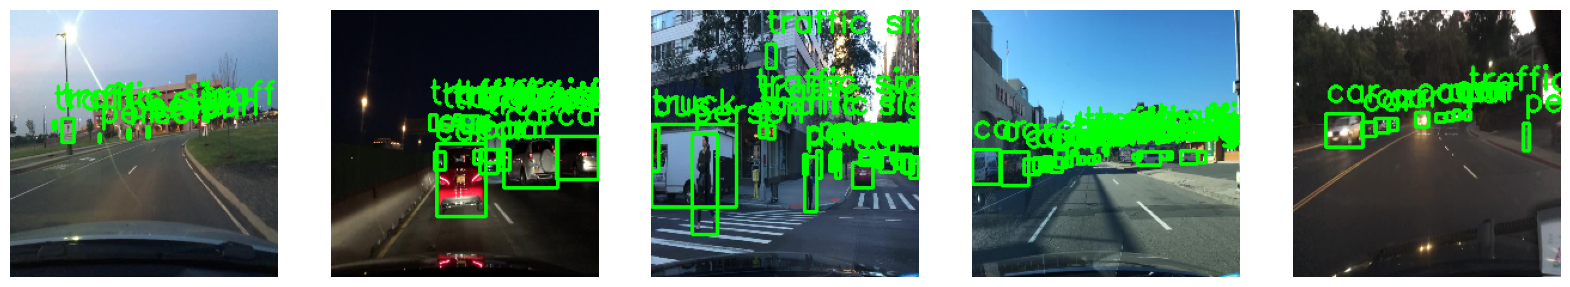

In [7]:
# Part 3: Plotting Images with Bounding Boxes

def plot_images_with_bboxes(images, bboxes, n_images=5):
    plt.figure(figsize=(20, 10))
    for i in range(n_images):
        img = images[i]
        bbox = bboxes[i]
        
        for box in bbox:
            xmin, ymin, xmax, ymax, label = box
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        plt.subplot(1, n_images, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

plot_images_with_bboxes(train_images, train_bboxes)


In [8]:
# Part 4: Prepare Data for Model Training

def custom_data_generator(images, bboxes, batch_size, labels):
    while True:
        for start in range(0, len(images), batch_size):
            end = min(start + batch_size, len(images))
            batch_images = []
            batch_labels = []
            for i in range(start, end):
                img = images[i]
                batch_images.append(img)
                
                # Initialize label array
                label_array = np.zeros(len(labels))
                
                for bbox in bboxes[i]:
                    label_index = labels.index(bbox[-1])
                    label_array[label_index] = 1  # One-hot encoding
                
                batch_labels.append(label_array)
            
            yield np.array(batch_images), np.array(batch_labels)

# Adjusted batch size
batch_size = 16

train_generator = custom_data_generator(train_images, train_bboxes, batch_size, labels)
val_generator = custom_data_generator(val_images, val_bboxes, batch_size, labels)


In [9]:
# Part 5: Load MobileNetV2 and Modify the Model

# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(labels), activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

c:\Users\sujal\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 block_10_expand (Conv2D)       (None, 14, 14, 384)  24576       ['block_9_add[0][0]']            
                                                                                                  
 block_10_expand_BN (BatchNorma  (None, 14, 14, 384)  1536       ['block_10_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_10_expand_relu (ReLU)    (None, 14, 14, 384)  0           ['block_10_expand_BN[0][0]']     
                                                                                                  
 block_10_depthwise (DepthwiseC  (None, 14, 14, 384)  3456       ['block_10_expand_relu[0][0]']   
 onv2D)                                                                                           
          

In [10]:
import scipy
print(scipy.__version__)


1.14.0


In [11]:
# Part 6: Train the Model

# Setup callbacks
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Train the model using GPU
with tf.device('/gpu:0'):
    history = model.fit(train_generator, 
                        validation_data=val_generator, 
                        epochs=10, 
                        steps_per_epoch=len(train_images) // batch_size, 
                        validation_steps=len(val_images) // batch_size, 
                        callbacks=[checkpoint, early_stopping])


Epoch 1/10
1250/1250 [==============================] - 84s 49ms/step - loss: 5801.4370 - accuracy: 0.4005 - val_loss: 13250.9590 - val_accuracy: 0.0020
Epoch 2/10
1250/1250 [==============================] - 45s 36ms/step - loss: 28251.2578 - accuracy: 0.3696 - val_loss: 38077.7422 - val_accuracy: 0.8280
Epoch 3/10
1250/1250 [==============================] - 44s 35ms/step - loss: 61522.8594 - accuracy: 0.3663 - val_loss: 72865.9453 - val_accuracy: 0.8280
Epoch 4/10
1250/1250 [==============================] - 43s 34ms/step - loss: 103682.8906 - accuracy: 0.3681 - val_loss: 114990.4688 - val_accuracy: 0.0055
Epoch 5/10
1250/1250 [==============================] - 45s 36ms/step - loss: 152887.2656 - accuracy: 0.3677 - val_loss: 160598.1406 - val_accuracy: 0.0055
Epoch 6/10
1250/1250 [==============================] - 44s 35ms/step - loss: 210181.4219 - accuracy: 0.3686 - val_loss: 215134.8281 - val_accuracy: 0.8280


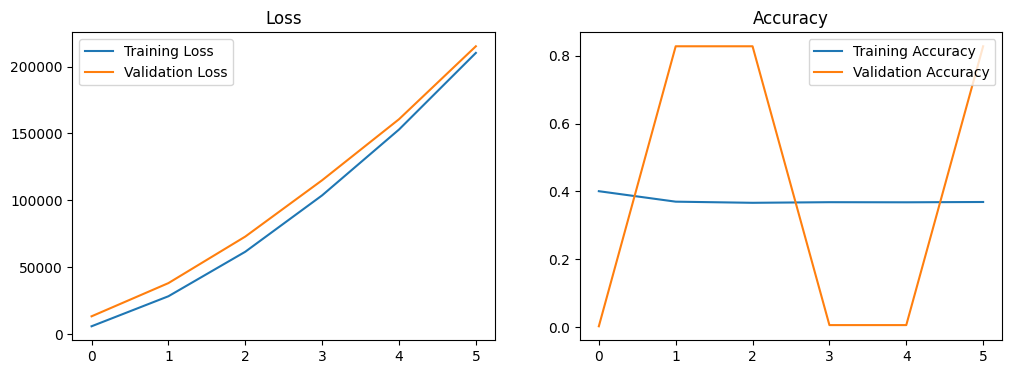

In [12]:
# Part 7: Plot Training and Validation Metrics

def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    
    plt.show()

plot_metrics(history)


In [13]:
# Part 8: Fine-Tune the Model

# Unfreeze some layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[checkpoint, early_stopping])

# Plot fine-tuning metrics
plot_metrics(history_fine)


Epoch 1/10
 130201/Unknown - 5156s 40ms/step - loss: 10304835.0000 - accuracy: 0.3473

KeyboardInterrupt: 

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# Part 9: Save the Model

model.save('final_model_mobilenet.h5')
